<a href="https://colab.research.google.com/github/angiellanos/MNIST_DF/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Se usan las funciones *_load_label* y *_load_img* para cargar el conjunto de datos del MNIST. Luego, se usa la función *train_test_split* de la librería *sklearn* para dividir el conjunto de datos en un conjunto de entrenamiento y uno de prueba, asegurándose de que ambos estén balanceados. Es decir, que tengan la misma proporción de imágenes para cada dígito. Se usa el parámetro *stratify* de la función *train_test_split* para lograr esto. El tamaño del conjunto de prueba es 10000, entonces el conjunto de prueba tiene 10000 imágenes y el conjunto de entrenamiento 50000 imágenes.

In [3]:
! git clone https://github.com/angiellanos/MNIST_DF.git

fatal: destination path 'MNIST_DF' already exists and is not an empty directory.


In [4]:
%cd MNIST_DF/

/content/MNIST_DF


In [5]:
print(os.getcwd())

/content/MNIST_DF


In [2]:
import os.path
import gzip
import pickle
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

files = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

image_size = 28
num_images = [60000, 10000]
num_labels = [60000, 10000]

def _load_label(file_key):
    """Función que carga las etiquetas de las imágenes desde un archivo comprimido en formato gzip.
    Args:
        file_name (str): el nombre del archivo que contiene las etiquetas
    Returns:
        array: etiquetas de las imágenes.
    """
    file_name = files[file_key]
    file_path = os.getcwd() + "/" + file_name

    j = 0 if file_key=='train_label' else 1
    with gzip.open(file_path, 'rb') as f:
        # omite los primeros 8 bytes
        f.read(8)
        buf = f.read(num_labels[j])
        label = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        # print(label[:20])

    return label

def _load_img(file_key):
    """Función que carga las imágenes desde un archivo comprimido en formato gzip.
    Args:
        file_name (str): el nombre del archivo que contiene las etiquetas
    Returns:
        array: imágenes en forma de vectores de tamaño 784.
    """
    file_name = files[file_key]
    file_path = os.getcwd() + "/" + file_name

    j = 0 if file_key=='train_img' else 1
    with gzip.open(file_path, 'rb') as f:
        # omite los primeros 16 bytes
        f.read(16)
        # cada pixel en 1 byte = 8 bits
        # lee todos los datos y los coloca en un buffer de memoria
        buf = f.read(image_size * image_size * num_images[j])
        # traslada los datos a un array de numpy de tipo float32
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        # Cambia la forma de los datos par entregarlos listos al dataset
        data = data.reshape(num_images[j], image_size, image_size, 1)

    return data

def _convert_numpy():
    """Función que convierte los datos del MNIST en arrays de NumPy y los guarda en dos diccionarios.
    Args: None
    Returns:
        dictionary: con las claves ‘train_img’, ‘train_label’, ‘test_img’ y ‘test_label’,
                   y los valores correspondientes a los arrays de NumPy con las imágenes
                   y las etiquetas.
    """
    # Cargar el conjunto de datos del MNIST usando las funciones _load_label y _load_img
    X_train = _load_img('train_img')
    y_train = _load_label('train_label')
    X_test = _load_img('test_img')
    y_test = _load_label('test_label')

    # Imprimir las dimensiones de los conjuntos de datos
    print("Dimensiones del conjunto de entrenamiento:")
    print(X_train.shape)
    print(y_train.shape)
    print("Dimensiones del conjunto de prueba:")
    print(X_test.shape)
    print(y_test.shape)

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = _convert_numpy()



FileNotFoundError: ignored

Una vez construidos los conjuntos de entrenamiento y prueba, se procede a construir el modelo de Naive Bayes. Para ello, se necesita calcular las probabilidades a priori de cada clase (P(c), donde c es la clase de cada dígito, p.e. la clase del 0, la del 1, hasta la del 9) y las probabilidades condicionales de cada píxel dado cada clase (P(x|c)). Estas probabilidades se pueden estimar a partir de los datos de entrenamiento usando la regla de Laplace, que consiste en añadir un pequeño valor (por ejemplo, 1) al numerador y al denominador de las frecuencias relativas.

Por lo tanto, la probabilidad a priori de cada clase $α$ (P(c=$α$)) está dada por:

In [69]:
# Contar el número total de imágenes
n_total = len(y_train)

# Crear una lista vacía para guardar las probabilidades a priori
p_c = []
n_c = []
# Recorrer las clases del 0 al 9
for c in range(10):
    # Contar el número de imágenes que tienen la etiqueta c
    n_c.append(np.sum(y_train == c))
    # Aplicar la regla de Laplace con un valor k=1
    p_c.append((n_c[c] + 1) / (n_total + 10))

# Convertir la lista en un array de numpy
p_c = np.array(p_c)
n_c = np.array(n_c)

print("P(C=c)=",p_c)

P(C=c)= [0.0987086  0.11237242 0.09929181 0.10218704 0.09737555 0.09035618
 0.09862529 0.10441575 0.09752135 0.09914601]


Estas probabilidades siempre serán cercanas a 0.1, que es la probabilidad esperada de cada dígito, dada por:

### $P(C=c)=\frac{Frecuencia \ del \ dígito}{Cantidad \ de \ dígitos}=\frac{1}{10}=0.1$

Debido a que son complementarias, su suma debe ser igual a 1. Verificando:

In [70]:
print("Suma de las probabilidades a priori:", np.sum(p_c))

Suma de las probabilidades a priori: 1.0


Para calcular las probabilidades condicionales de cada píxel dado cada clase (P(x|c)), necesitas contar el número de veces que cada píxel tiene un valor mayor que cero en las imágenes de cada clase. Esto se puede hacer usando la función where de numpy, que te permite seleccionar los elementos de un array que cumplen una condición. Por ejemplo, para calcular la probabilidad condicional del primer píxel dado la clase 0 (P(x1|c=0)), puedes hacer lo siguiente:

In [1]:
# Crear una lista vacía para guardar las probabilidades condicionales
p_x_c = []
# Recorrer las clases del 0 al 9
for c in range(10):
    # Seleccionar las imágenes que tienen la etiqueta c
    X_c = X_train[np.where(y_train == c)]
    # Crear una lista vacía para guardar las probabilidades condicionales de cada píxel dado la clase c
    p_x_c_c = []
    # Recorrer los píxeles del 1 al 784
    for i in range(5):
        # Calcular el índice de la fila y la columna del píxel i
        row = i // 28
        col = i % 28
        print(row, col)
        # Contar el número de imágenes que tienen el píxel i mayor o igual que cero
        n_xi_c = np.sum(X_c[:, row, col, 0] > 0.1)
        # Aplicar la regla de Laplace con un valor k=1
        p_xi_c = (n_xi_c + 1) / (n_c[c] + 2)
        # Añadir la probabilidad condicional a la lista
        p_x_c_c.append(p_xi_c)
    # Convertir la lista en un array de numpy y añadirlo a la lista principal
    p_x_c.append(np.array(p_x_c_c))
# Convertir la lista principal en un array de numpy
p_x_c = np.array(p_x_c)

# print(p_x_c)

NameError: ignored

In [72]:
print("Suma de las probabilidades condicionales por clase:", np.sum(p_x_c, axis=1))


Suma de las probabilidades condicionales por clase: [191.93945148  85.96478873 168.96266779 163.63888323 141.70380667
 152.54989629 157.54624155 131.48883127 173.12449285 142.62570888]


1
Shape del lote de imágenes: torch.Size([64, 28, 28, 1])
Shape del lote de etiquetas: torch.Size([64])


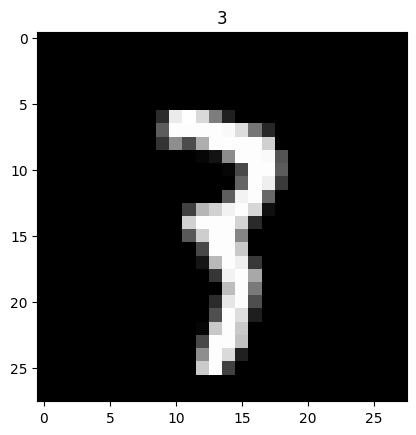

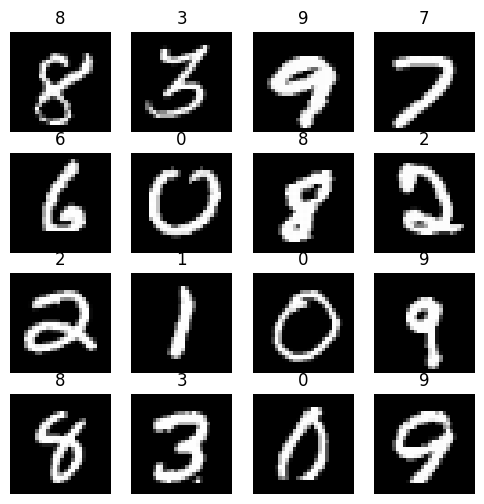

In [ ]:


## Preparando los datos para entrenamiento con DataLoaders
num_workers = torch.get_num_threads()//2

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers= num_workers)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(torch.get_num_threads())

len(next(iter(test_dataloader)))


## Iterando a lo largo del DataLoader

# Despliega imagen y etiqueta
train_features, train_labels = next(iter(train_dataloader))
print(f'Shape del lote de imágenes: {train_features.size()}')
print(f'Shape del lote de etiquetas: {train_labels.size()}')
img = train_features[0].squeeze()# primer elemento del batch
# squeeze elimina ejes de tamaño 1.
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.title(label.numpy())
plt.show()

class Draw:
    def __init__(self, label_map, images_iterator, cols=4, rows=4, figsize=(6,6)):
        self.data = images_iterator
        self.label_map = label_map
        self.figsize=figsize
        self.cols = cols
        self.rows = rows
        self.index = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            raise StopIteration

        self.index += 1

        img, label = next(self.data)
        figure = plt.figure(figsize=self.figsize)
        for i in range(1, self.cols*self.rows+1):
            #sample_idx = torch.randint(len(training_data), size =(1,)).item()
            #img, label = training_data[sample_idx]
            figure.add_subplot(self.rows, self.cols, i)
            #plt.title(self.label_map[label])
            plt.axis('off')
            plt.imshow(img[i].squeeze(), cmap='gray')
            plt.title(label[i].numpy())
        plt.show()
        #return value

label_map = {
    0: 'camiseta',
    1: "Pantalones",
    2: "Jersey",
    3: "Vestido",
    4: "Abrigo",
    5: "Sandalia",
    6: "Camisa",
    7: "Tenis",
    8: "Bolso",
    9: "Botines",
}

images = Draw(label_map, iter(train_dataloader))

next(images)

In [ ]:
import os.path
import gzip
import pickle
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

files = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

image_size = 28
num_images = [60000, 10000]
num_labels = [60000, 10000]

def _load_label(file_key):
    file_name = files[file_key]
    file_path = os.getcwd() + "/" + file_name

    j = 0 if file_key=='train_label' else 1
    with gzip.open(file_path, 'rb') as f:
        f.read(8)
        buf = f.read(num_labels[j])
        label = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)

    return label

def _load_img(file_key):
    file_name = files[file_key]
    file_path = os.getcwd() + "/" + file_name

    j = 0 if file_key=='train_img' else 1
    with gzip.open(file_path, 'rb') as f:
        f.read(16)
        buf = f.read(image_size * image_size * num_images[j])
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images[j], image_size, image_size, 1)

    return data

def _convert_numpy():
    X_train = _load_img('train_img')
    y_train = _load_label('train_label')
    X_test = _load_img('test_img')
    y_test = _load_label('test_label')

    print("Dimensiones del conjunto de entrenamiento:")
    print(X_train.shape)
    print(y_train.shape)
    print("Dimensiones del conjunto de prueba:")
    print(X_test.shape)
    print(y_test.shape)

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = _convert_numpy()